In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# SLCP experiment

In [4]:
from simulators import SLCP
from datasets import LTEDataset
from models import Flatten, MNRE
from criterions import WeightedLoss, RELoss, RDLoss
from samplers import TractableSampler, NRESampler
from histograms import pairhist, corner

## Simulator 

In [5]:
simulator = SLCP().to(device)
simulator.sample()

(tensor([ 0.1994,  2.1933, -2.5000,  2.2728,  2.8325], device='cuda:0'),
 tensor([[-5.6207, -1.8386],
         [ 3.4421,  4.2314],
         [ 4.2250,  5.1608],
         [12.6858, 12.1786]], device='cuda:0'))

In [6]:
trainset = LTEDataset(simulator, mode=-1)

## Model

In [7]:
joint_subsets = torch.tensor([
    [False, False, False, True, True],
    [False, False, True, True, True],
    [True, True, True, True, True]
])

joint_subsets

tensor([[False, False, False,  True,  True],
        [False, False,  True,  True,  True],
        [ True,  True,  True,  True,  True]])

In [8]:
model = MNRE(masks=joint_subsets, encoder=Flatten((4, 2)), num_layers=10, hidden_size=512, activation=nn.SELU).to(device)
criterion = WeightedLoss([RDLoss(joint_subsets)], [.01]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=1e-1, patience=5, threshold=1e-2, verbose=True)

In [9]:
model.load_state_dict(torch.load('mnre.pth', map_location=device))

<All keys matched successfully>

### Train

In [10]:
model.train()

epoch = 0
epoch_size = 256

losses = []

for thetas, xs, mask in trainset:
    ratios = model(thetas, xs)
    loss = criterion(ratios, mask)

    losses.append(loss.tolist())

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.)
    optimizer.step()

    if len(losses) == epoch_size:
        losses = torch.tensor(losses)

        print(f'{epoch}: {losses.mean()} +- {losses.std()}')
        scheduler.step(losses.mean())

        epoch += 1
        losses = []

        if optimizer.param_groups[0]['lr'] < 1e-6:
            break

0: 98.644287109375 +- 1075.498291015625
1: 48402.21484375 +- 773179.125
2: 149.67674255371094 +- 1116.986572265625
3: 53.2300910949707 +- 332.8275146484375
4: 40454.09765625 +- 405289.4375
5: 51.571956634521484 +- 377.5035400390625
6: 39.742408752441406 +- 205.772705078125
7: 284.84375 +- 4086.56884765625
8: 7926.67041015625 +- 125384.7890625
9: 582.755615234375 +- 7645.1064453125
10: 54.69756317138672 +- 347.2251892089844
11: 23.73029899597168 +- 71.05154418945312
12: 28.81005096435547 +- 130.82144165039062
13: 771.18359375 +- 11038.1103515625
14: 96.79582977294922 +- 939.891845703125
15: 127.76197052001953 +- 775.2559204101562
16: 119.95698547363281 +- 794.6471557617188
17: 35.05229568481445 +- 164.87518310546875
Epoch    18: reducing learning rate of group 0 to 1.0000e-06.
18: 369.3642883300781 +- 4588.7607421875
19: 298.66827392578125 +- 3004.32373046875
20: 73.24983215332031 +- 696.2222290039062
21: 63.02401351928711 +- 484.3455810546875
22: 45.579402923583984 +- 219.7066802978515

## Metropolis-Hastings

In [11]:
low = simulator.low.cpu()
high = simulator.high.cpu()

In [12]:
theta_star = torch.tensor([0.7, -2.9, -1., -0.9,  0.6]).to(device)
x_star = torch.tensor([
    [-0.48406151, -3.13977371],
    [-0.43098274, -3.50238278],
    [-0.03512463, -2.87554796],
    [ 1.43279532, -2.80650507]
]).to(device)

In [13]:
x_star = x_star.expand(2 ** 12, -1, -1)

### MNRE

In [14]:
model.eval()
z_star = model.encoder(x_star)

#### 4 & 5

In [15]:
mask, nre = model[0]
mask = mask.cpu()

In [16]:
labels = [f'$\\theta_{{{i}}}$' for i in [4, 5]]

In [17]:
sampler = NRESampler(simulator.subprior(mask), nre, z_star, sigma=0.1)
samples = sampler(4096)
hists = pairhist(samples, low[mask], high[mask], bins=60, normed=True, bounded=True)

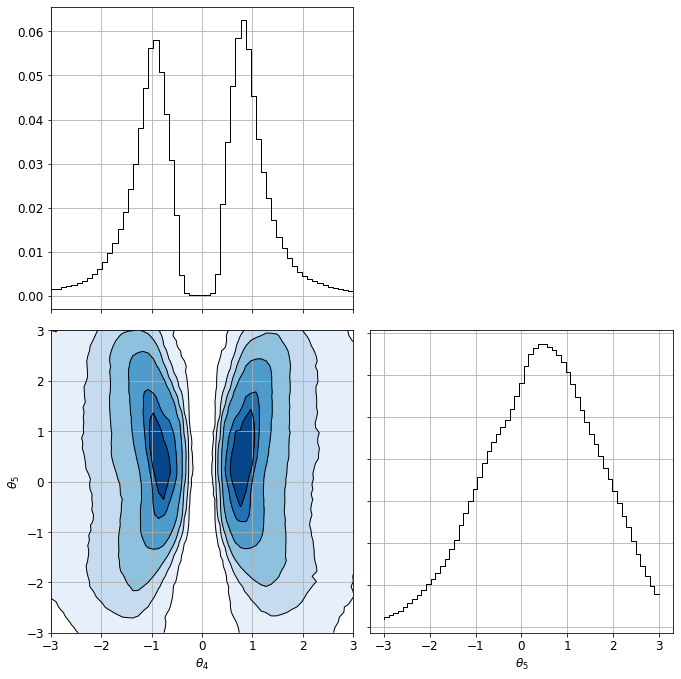

In [18]:
fig = corner(hists, low[mask], high[mask], labels=labels)

#### 3, 4 & 5

In [19]:
mask, nre = model[1]
mask = mask.cpu()

In [20]:
labels = [f'$\\theta_{{{i}}}$' for i in [3, 4, 5]]

In [21]:
sampler = NRESampler(simulator.subprior(mask), nre, z_star, sigma=0.1)
samples = sampler(4096)
hists = pairhist(samples, low[mask], high[mask], bins=60, normed=True, bounded=True)

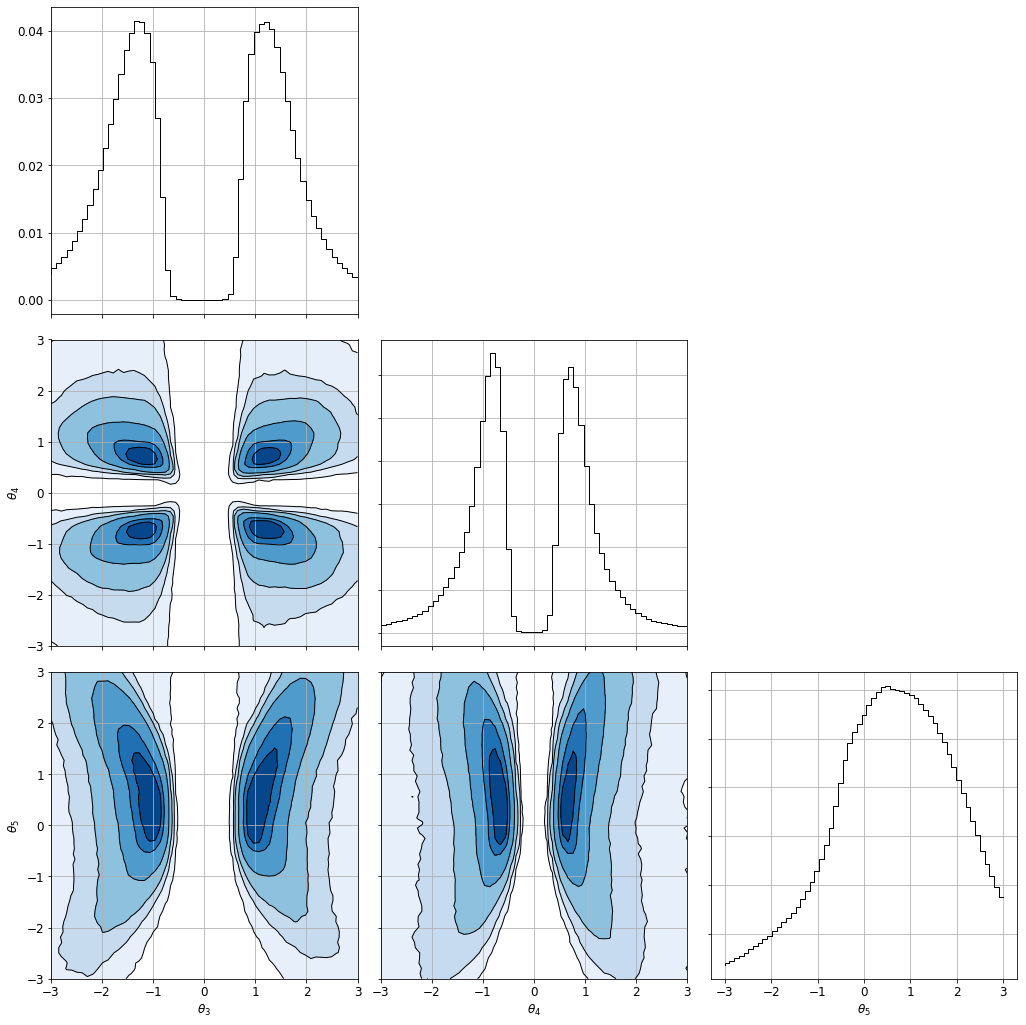

In [22]:
fig = corner(hists, low[mask], high[mask], labels=labels)